In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/')
import sqlite3
db_file = "database.db"
conn = sqlite3.connect(db_file)
cursor = conn.cursor()


cursor.execute('''
    CREATE TABLE IF NOT EXISTS speakers (
        ID INTEGER PRIMARY KEY,
        SEX TEXT,
        SUBSET TEXT,
        MINUTES REAL,
        NAME TEXT
    )
''')

In [3]:
import csv
import sys
csv_file = "/content/drive/MyDrive/cnn-speaker-id/speakers.csv"
sys.path.append('/content/drive/MyDrive/cnn-speaker-id')
with open(csv_file, 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)
    for row in csv_reader:
        if len(row) == 5:
            cursor.execute('''
                INSERT OR REPLACE INTO speakers (ID, SEX, SUBSET, MINUTES, NAME)
                VALUES (?, ?, ?, ?, ?)
            ''', (int(row[0]), row[1], row[2], float(row[3]), row[4]))
conn.commit()
conn.close()
print(f"Data successfully imported from {csv_file} to {db_file}")

Data successfully imported from /content/drive/MyDrive/cnn-speaker-id/speakers.csv to database.db


In [ ]:
from keras.api.preprocessing.sequence import pad_sequences
from keras.api.metrics import Precision, Recall
from keras.api.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import numpy as np
from keras.api.callbacks import ReduceLROnPlateau, EarlyStopping
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from keras.api.models import Sequential
from keras.api.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     BatchNormalization, Dropout, InputLayer)
def create_model(num_classes):
    model = Sequential([
        InputLayer(shape=(369, 496, 1)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [6]:
import cv2
import librosa

def get_spectogram(audio_path):
    y, sr = librosa.load(audio_path,sr=16000)
    S = np.abs(librosa.stft(y, n_fft=1024, hop_length=512))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min())
    S_img = (S_norm * 255).astype(np.uint8)
    target_size = (496, 369)
    S_resized = cv2.resize(S_img, target_size, interpolation=cv2.INTER_AREA)
    return S_resized

In [7]:
def rm_silence(input_file, sr, top_db=30):
    y, sr = librosa.load(input_file, sr=sr)
    intervals = librosa.effects.split(y, top_db=top_db)
    non_silent_audio = np.concatenate([y[start:end] for start, end in intervals])
    return non_silent_audio

In [8]:
def resize_data(S_resized):
    X = np.expand_dims(S_resized, axis=-1) / 255.0
    return X

In [9]:
def get_speaker_name_from_db(speaker):
    connection = sqlite3.connect('database.db')
    cursor = connection.cursor()
    cursor.execute("SELECT name FROM speakers WHERE id=?", (speaker,))
    result = cursor.fetchone()
    connection.close()
    if result:
        return result[0]
    else:
        return None

In [10]:
import os

In [11]:
def count_files_recursive(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

In [12]:
def list_files_recursive(path):
    file_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
          if file.endswith('.flac'):
            file_list.append(os.path.join(root, file))
    return file_list

In [13]:
import random
from sklearn.model_selection import train_test_split

def prepare_dataset(path):
    X_train, y_train = [], []
    X_test, y_test = [], []

    speakers = os.listdir(path)

    for speaker in speakers:
        speaker_path = os.path.join(path, speaker)
        if not os.path.isdir(speaker_path):
            continue
        speaker_name = get_speaker_name_from_db(speaker)
        print(speaker_name)
        files = list_files_recursive(speaker_path)
        random.shuffle(files)
        split_idx = int(0.8 * len(files))
        train_files = files[:split_idx]
        test_files = files[split_idx:]
        print('#### Training files ####')
        for file in train_files:
            try:
              S_resized = get_spectogram(file)
              X_train.append(resize_data(S_resized))
              y_train.append(speaker_name)
            except Exception as e:
                print(f"[Train] Failed on {file}: {e}")
        print('#### Testing files ####')
        for file in test_files:
            try:
                S_resized = get_spectogram(file)
                X_test.append(resize_data(S_resized))
                y_test.append(speaker_name)
            except Exception as e:
                print(f"[Test] Failed on {file}: {e}")

    return X_train, y_train, X_test, y_test


In [14]:
DATASET_DIR='/content/drive/MyDrive/cnn-speaker-id/data'
X_train_raw, y_train_raw, X_test, y_test = prepare_dataset(DATASET_DIR)
print(f"Number of training examples: {len(X_train_raw)}")
print(f"Number of testing examples: {len(X_test)}")
print(f"Number of classes: {len(set(y_train_raw))}")
print(f"Classes: {set(y_train_raw)}")

Michele Fry
#### Training files ####
#### Testing files ####
thecheops
#### Training files ####
#### Testing files ####
Leanne Kinkopf
#### Training files ####
#### Testing files ####
Michelle Goode
#### Training files ####
#### Testing files ####
Sam Stinson
#### Training files ####
#### Testing files ####
David Jenkins
#### Training files ####
#### Testing files ####
Tim Bower
#### Training files ####
#### Testing files ####
KalenXI
#### Training files ####
#### Testing files ####
Bill Kneeland
#### Training files ####
#### Testing files ####
Nodo420
#### Training files ####
#### Testing files ####
Nolan Fout
#### Training files ####
#### Testing files ####
LadyBug
#### Training files ####
#### Testing files ####
Taylor Burton-Edward
#### Training files ####
#### Testing files ####
Paul-Gabriel Wiener
#### Training files ####
#### Testing files ####
Rachael Lapidis
#### Training files ####
#### Testing files ####
Ulf Bjorklund
#### Training files ####
#### Testing files ####
airandwa

In [15]:
from keras.api.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_train_raw)
y_cat = to_categorical(y_encoded)

In [16]:
classes = le.classes_.tolist()
print('classes: ',classes)

classes:  ['AJai Hilton', 'Akram Fadel', 'Ammar Kaba', 'Bill Kneeland', 'Brad Bush', 'Daniel Anaya', 'David Jenkins', 'Dianne', 'Duncan Murrell', 'Heather Hogan', 'Jen Maxwell', 'KalenXI', 'LadyBug', 'Leanne Kinkopf', 'Leni', 'Mary Ballard-Johansson', 'Michele Fry', 'Michelle Goode', 'Mitchell L Leopard', 'Nikolle Doolin', 'Nodo420', 'Nolan Fout', 'Paul-Gabriel Wiener', 'Peter Bobbe', 'Rachael Lapidis', 'Rachel Nelson-Smith', 'Sam Stinson', 'Taylor Burton-Edward', 'Tim Bower', 'Tim Perkins', 'TinyPines', 'Ulf Bjorklund', 'airandwaters', 'amycsj', 'elongman', 'number6', 'rachelellen', 'sarac', 'supergirl', 'thecheops']


In [17]:
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    X_train_raw, y_cat, test_size=0.2, stratify=y_encoded, random_state=42
)

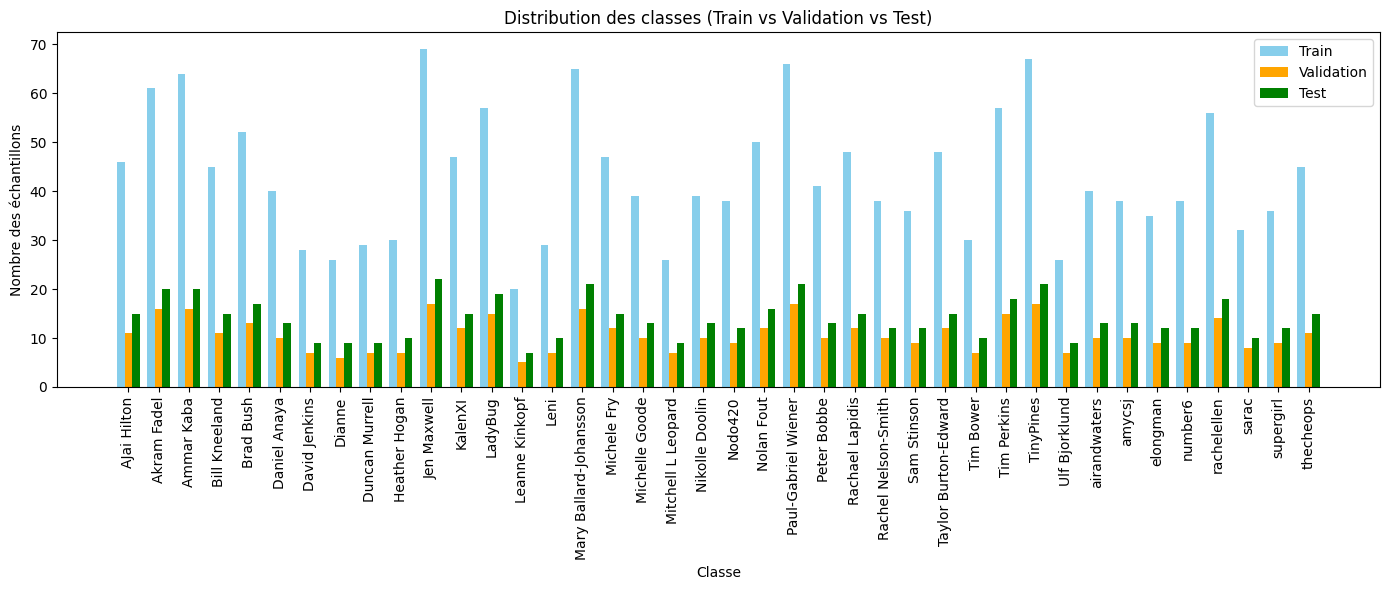

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

y_test_encoded = le.transform(y_test)


train_counts = Counter(np.argmax(y_train_cat, axis=1))
val_counts = Counter(np.argmax(y_val_cat, axis=1))
test_counts = Counter(y_test_encoded)

all_classes = sorted(set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys())))


train_values = [train_counts.get(cls, 0) for cls in all_classes]
val_values = [val_counts.get(cls, 0) for cls in all_classes]
test_values = [test_counts.get(cls, 0) for cls in all_classes]


x = np.arange(len(all_classes))
width = 0.25


plt.figure(figsize=(14, 6))
plt.bar(x - width, train_values, width, label='Train', color='skyblue')
plt.bar(x, val_values, width, label='Validation', color='orange')
plt.bar(x + width, test_values, width, label='Test', color='green')

plt.xlabel('Classe')
plt.ylabel('Nombre des échantillons')
plt.title('Distribution des classes (Train vs Validation vs Test)')
plt.xticks(x, [le.classes_[i] for i in all_classes], rotation=90)  # show actual class names
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
model = create_model(num_classes=y_cat.shape[1])

In [20]:
import tensorflow as tf
from keras import backend as K

def categorical_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return loss

In [21]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
model.compile(optimizer='adam', loss=categorical_focal_loss(alpha=0.25, gamma=2), metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = model.fit(
    np.array(X_train), np.array(y_train_cat),
    validation_data=(np.array(X_val), np.array(y_val_cat)),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
